In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import re
import nltk
import torch   
import spacy
import torch
import string
import pandas as pd
import torch.nn as nn
from torchtext import data
import torch.optim as optim 
import torchtext.data as data
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [6]:

df = pd.read_csv("small.csv",header=None)

In [7]:
df_new = df.rename(columns={0: 'Text',1:"Label"})

In [8]:
df_new.to_csv("dataset.csv",encoding="utf-8-sig")

In [9]:

nltk.download('stopwords')
stop_words = set(stopwords.words('turkish') + ["bir","in","nın","dedi",",","nin","de","olarak","ın","\'","ilk","olan","olarak","son","’","a","sonra","var","kadar","göre"]) 

def tokenize (text):
    text = text.replace("\\","/")
    text = text.replace("./","/content/")
    text = open(text,"r",encoding="utf-8").readlines()
    text  = ' '.join(map(str, text)) 
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text.lower())
    word_tokens = word_tokenize(nopunct) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]   
    return filtered_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
TEXT = data.Field(tokenize=tokenize,batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [11]:
fields = [(None, None), ('text',TEXT),('label', LABEL)]

In [12]:
nltk.download('punkt')
training_data=data.TabularDataset(path = 'dataset.csv',format = 'csv',fields = fields,skip_header = True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
import random
train_data, valid_data = training_data.split(split_ratio=0.85, random_state = random.seed(42))

In [14]:
vars(train_data.examples[42])

{'label': 'spor',
 'text': ['fenerbahçeli',
  'alex',
  'olmak',
  'istiyor',
  'acıbadem',
  'bayanlar',
  'voleybol',
  'ligi',
  'ekiplerinden',
  'fenerbahçe',
  'güney',
  'koreli',
  'milli',
  'oyuncusu',
  'yeon',
  'koung',
  'sarı',
  'lacivertli',
  'takımın',
  'unutulmaz',
  'futbolcularından',
  'alex',
  'uzun',
  'yıllar',
  'takımında',
  'forma',
  'giymek',
  'istediğini',
  'söyledi',
  'koung',
  'kendisine',
  'yapılan',
  'voleybol',
  'takımının',
  'alex',
  'i',
  'yakıştırması',
  'ilgili',
  'alex',
  'fenerbahçe',
  'yıl',
  'uzun',
  'zaman',
  'futbol',
  'oynadı',
  'ben',
  'sadece',
  'yıldır',
  'takımda',
  'forma',
  'giyiyorum',
  'sözü',
  'hak',
  'etmek',
  'henüz',
  'erken',
  'tabii',
  'ben',
  'alex',
  'uzun',
  'yıllar',
  'fenerbahçe',
  'forma',
  'giymek',
  'istiyorum',
  'fenerbahçe',
  'yi',
  'seviyorum',
  'konuştu',
  'güney',
  'kore',
  'japonya',
  'dan',
  'voleybolcuların',
  'türkiye',
  'ye',
  'gelip',
  'forma',
  'giyme

In [15]:
TEXT.build_vocab(train_data,min_freq=3)  
LABEL.build_vocab(train_data)

print(TEXT.vocab.freqs.most_common(10))  

[('türkiye', 17709), ('yüzde', 12377), ('olduğunu', 11500), ('büyük', 11194), ('bin', 10831), ('yeni', 10399), ('oldu', 9278), ('söyledi', 8860), ('iyi', 8835), ('milyon', 8648)]


In [16]:
device = torch.device('cuda')  
BATCH_SIZE = 64

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [17]:
class LSTM_(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 64)
        self.out = nn.Linear(64, 7)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        x = self.linear(ht[-1])
        return self.out(x)
      

In [18]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 128
num_layers = 2
bidirection = True
dropout = 0.2

model = LSTM_(size_of_vocab, embedding_dim, num_hidden_nodes)

In [19]:
device="cuda"
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [20]:
def test(model, iterator, optimizer, criterion):
    train_total = 0
    train_correct=0
    model.eval()  
    
    for batch in iterator:
        optimizer.zero_grad()   
        
        text, text_lengths = batch.text   
        text = text.long()
        text_lengths=text_lengths.long()
        predictions = model(text, text_lengths).squeeze()  
        train_total += batch.label.size(0)
        _,preds = torch.max(predictions,1)
        train_correct += (preds == batch.label).sum().item()   
        
    return train_correct / train_total


In [21]:
N_EPOCHS = 16

train_hist = []
test_hist = []
loss_hist = []

for epoch in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    train_total = 0
    train_correct=0
    model.train()  

    for batch in train_iterator:

        optimizer.zero_grad()   
        text, text_lengths = batch.text   
        text = text.long()
        text_lengths=text_lengths.long()
        predictions = model(text, text_lengths).squeeze()  
        loss = criterion(predictions, batch.label.long())        
        loss.backward()       
        
        optimizer.step()      
        epoch_loss += loss.item()  
        train_total += batch.label.size(0)
        _,preds = torch.max(predictions,1)
        train_correct += (preds == batch.label).sum().item()   
    train_acc = train_correct / train_total
    test_acc = test(model,valid_iterator,optimizer,criterion)
    train_hist.append(train_acc)
    test_hist.append(test_acc)
    loss_hist.append(epoch_loss / len(train_iterator))
    print( epoch_loss / len(train_iterator), train_acc)


1.6031135291625291 0.4013971414806488
1.38912507830522 0.4867512445800546
1.0205904121582325 0.6190380600610246
0.8357728541661531 0.6908222257909106
0.6870141189067792 0.7472298056849205
0.5727273552845686 0.7919543921631604
0.4842470232110757 0.8250361329693271
0.4125360415149958 0.8504496547294043
0.35587274111234224 0.8719688453508913
0.29546607331587715 0.8960976393126706


KeyboardInterrupt: ignored

In [29]:
model.eval()  

p = []
l = []
    
for batch in valid_iterator:
    text, text_lengths = batch.text   
    text = text.long()
    text_lengths=text_lengths.long()
    predictions = model(text, text_lengths).squeeze()  
    train_total += batch.label.size(0)
    _,preds = torch.max(predictions,1)
    for i in preds:
      p.append(i.item())
    for i in batch.label:
      l.append(i.item())
    train_correct += (preds == batch.label).sum().item()   

In [32]:
import numpy as np
p = np.array(p)
l = np.array(l)

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(l, p)

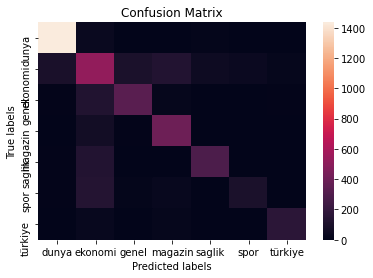

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['dunya', 'ekonomi',"genel","magazin","saglik","spor","türkiye"]); ax.yaxis.set_ticklabels(['dunya', 'ekonomi',"genel","magazin","saglik","spor","türkiye"]);